Disease classification
By Yahia Bourraoui

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt


# Load the datasets
train_data_path = 'train_data.csv'
test_data_path = 'test_data.csv'

# Load the datasets into DataFrames
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Display the first few rows of the training data
print(train_data.head())


    Glucose  Cholesterol  Hemoglobin  Platelets  White Blood Cells  \
0  0.739597     0.650198    0.713631   0.868491           0.687433   
1  0.121786     0.023058    0.944893   0.905372           0.507711   
2  0.452539     0.116135    0.544560   0.400640           0.294538   
3  0.136609     0.015605    0.419957   0.191487           0.081168   
4  0.176737     0.752220    0.971779   0.785286           0.443880   

   Red Blood Cells  Hematocrit  Mean Corpuscular Volume  \
0         0.529895    0.290006                 0.631045   
1         0.403033    0.164216                 0.307553   
2         0.382021    0.625267                 0.295122   
3         0.166214    0.073293                 0.668719   
4         0.439851    0.894991                 0.442159   

   Mean Corpuscular Hemoglobin  Mean Corpuscular Hemoglobin Concentration  \
0                     0.001328                                   0.795829   
1                     0.207938                                   0.505

In [2]:
# Check for missing values
print(train_data.isnull().sum())

# Example: Fill missing values with the mean for numerical columns and mode for categorical columns
for column in train_data.columns:
    if train_data[column].dtype == 'object':
        train_data[column].fillna(train_data[column].mode()[0], inplace=True)
    else:
        train_data[column].fillna(train_data[column].mean(), inplace=True)


Glucose                                      0
Cholesterol                                  0
Hemoglobin                                   0
Platelets                                    0
White Blood Cells                            0
Red Blood Cells                              0
Hematocrit                                   0
Mean Corpuscular Volume                      0
Mean Corpuscular Hemoglobin                  0
Mean Corpuscular Hemoglobin Concentration    0
Insulin                                      0
BMI                                          0
Systolic Blood Pressure                      0
Diastolic Blood Pressure                     0
Triglycerides                                0
HbA1c                                        0
LDL Cholesterol                              0
HDL Cholesterol                              0
ALT                                          0
AST                                          0
Heart Rate                                   0
Creatinine   

C:\Users\exe\AppData\Local\Temp\ipykernel_15924\2494327029.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[column].fillna(train_data[column].mean(), inplace=True)
C:\Users\exe\AppData\Local\Temp\ipykernel_15924\2494327029.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

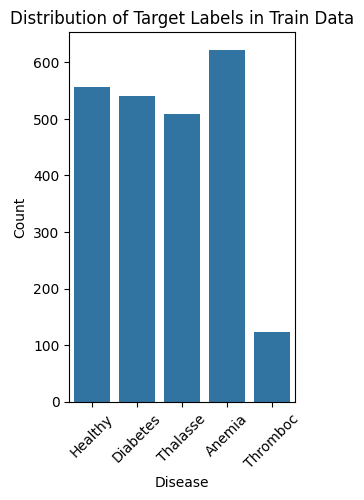

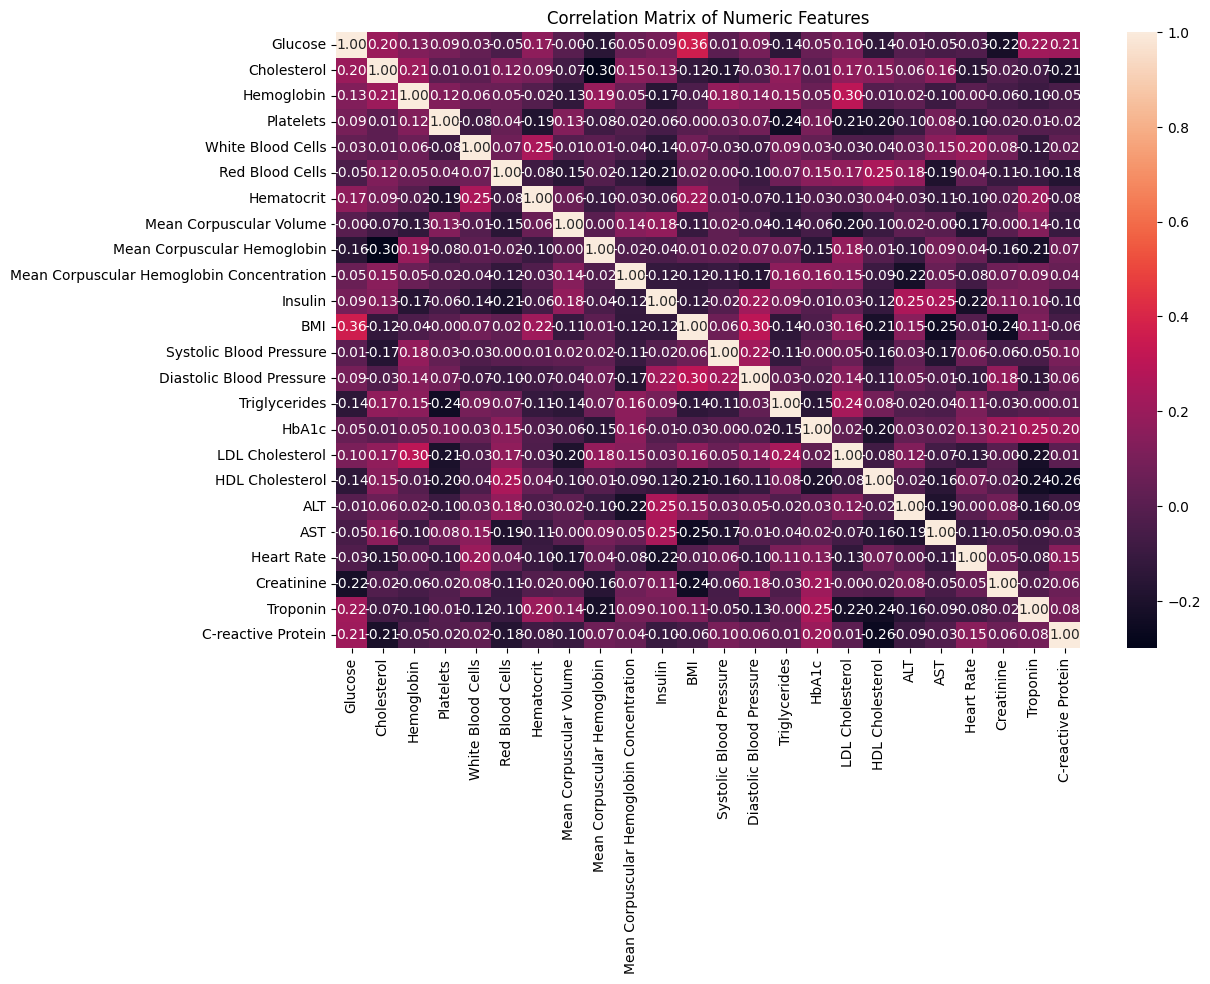

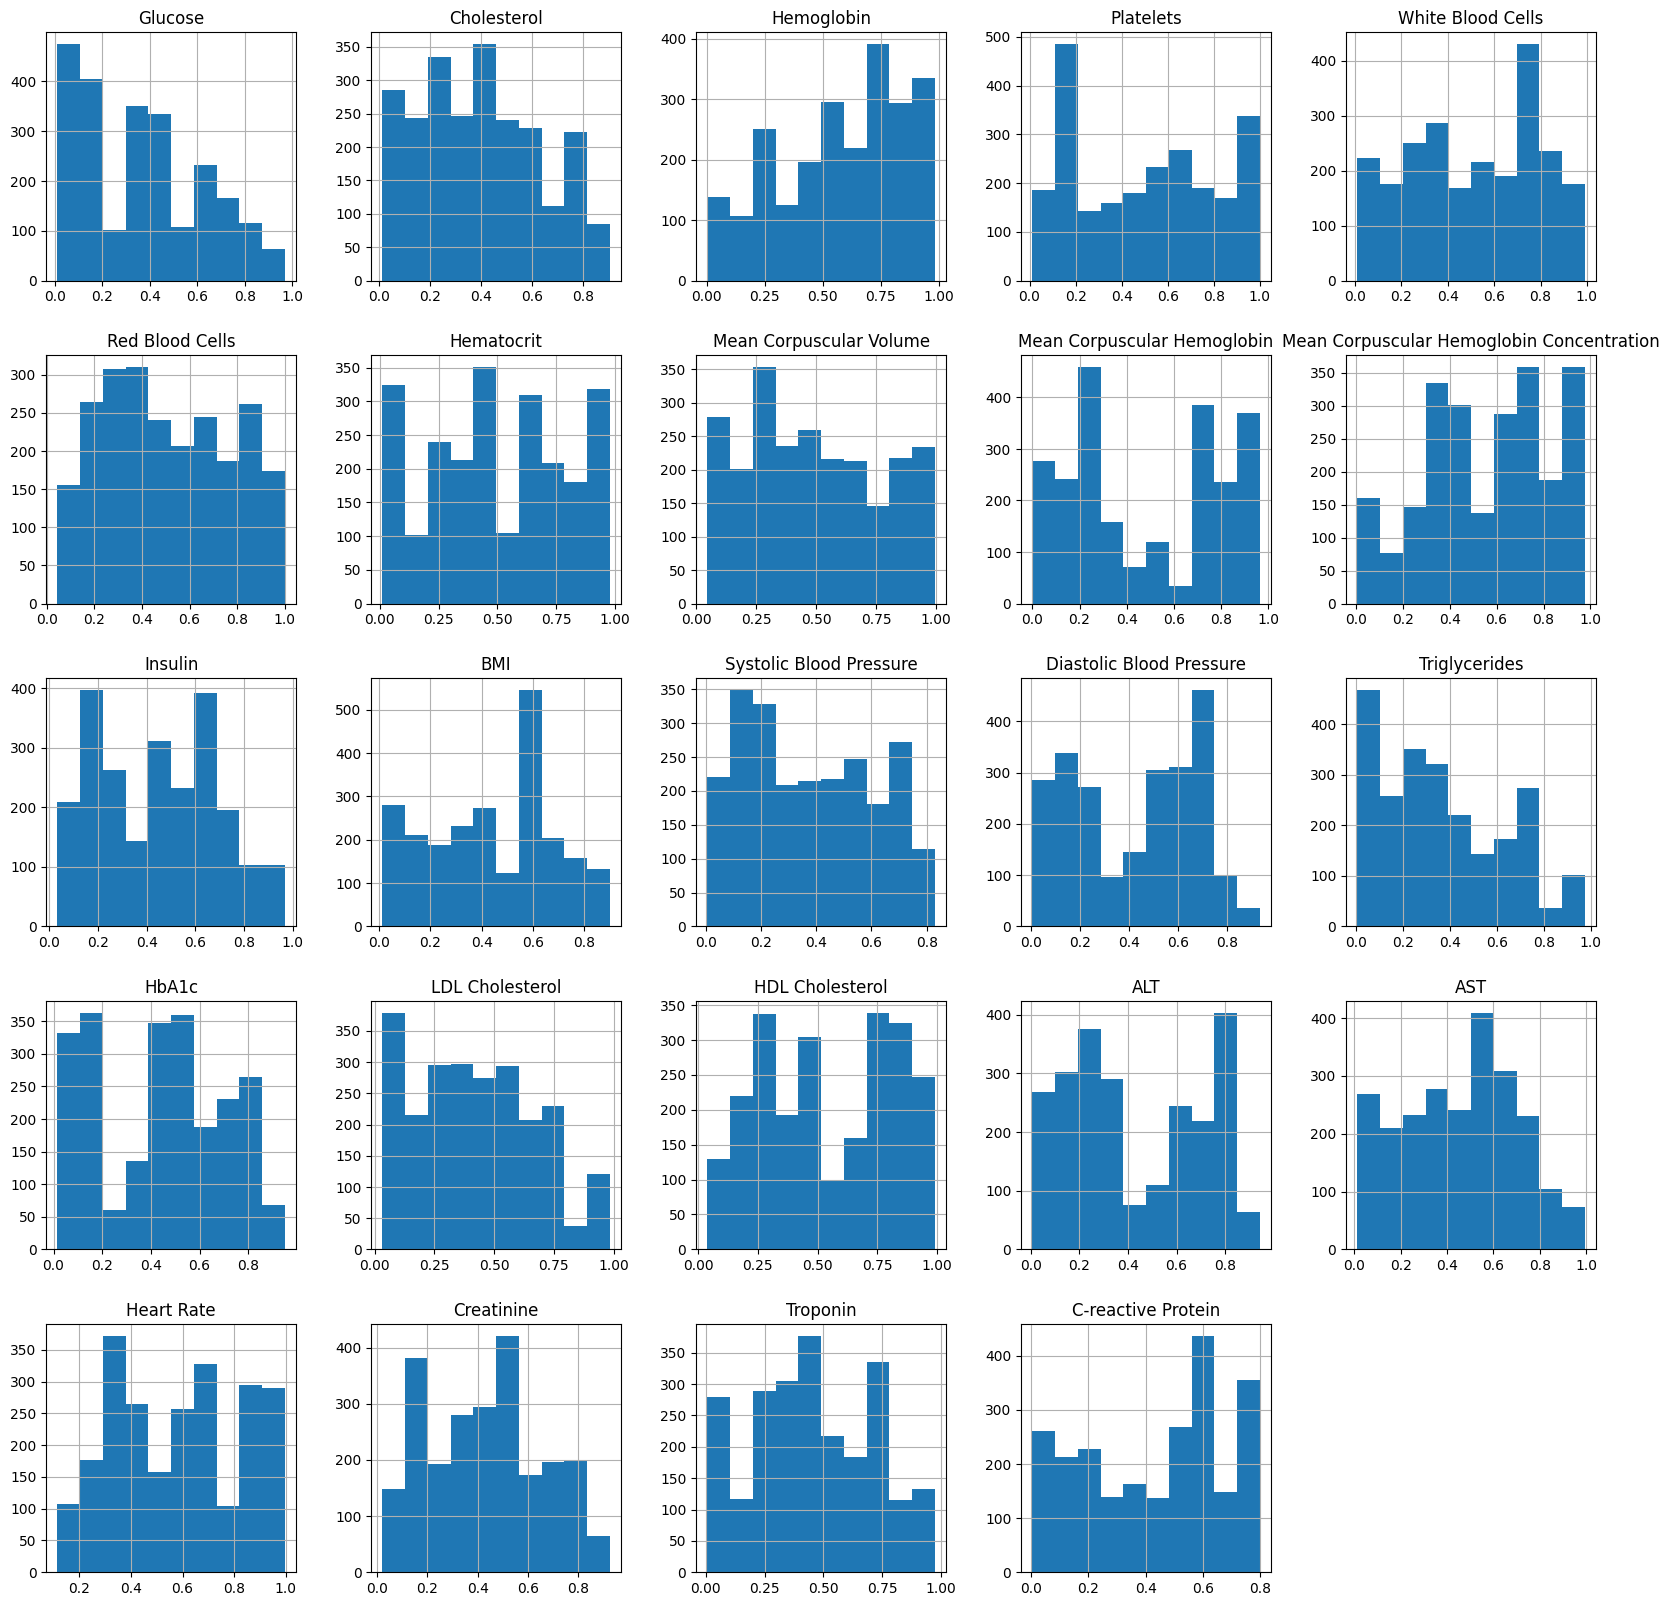

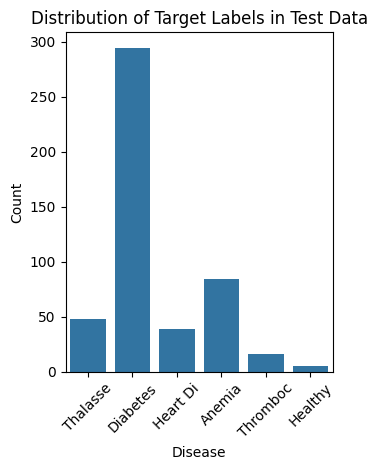

In [3]:
# Plot the distribution of the target variable
plt.subplot(1, 2, 1)
sns.countplot(data=train_data, x='Disease')
plt.title('Distribution of Target Labels in Train Data')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)


# Filter out non-numeric columns for the correlation heatmap
numeric_columns = train_data.select_dtypes(include=[float, int]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(train_data[numeric_columns].corr(), annot=True, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Visualize feature distributions
train_data.hist(figsize=(20, 20))
plt.show()

# Plot the distribution of target labels in the test dataset
plt.subplot(1, 2, 2)
sns.countplot(data=test_data, x='Disease')
plt.title('Distribution of Target Labels in Test Data')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [4]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [5]:
# Remove outliers from train_data
columns_to_check = train_data.columns.drop('Disease')
train_data = remove_outliers(train_data, columns_to_check)


In [6]:
# Encode the target variable 'Disease'
le = LabelEncoder()

# Identify unseen labels in the test set
train_labels = set(train_data['Disease'])
test_labels = set(test_data['Disease'])
unseen_labels = test_labels - train_labels

# Filter out the rows with unseen labels in the test set
test_data_filtered = test_data[~test_data['Disease'].isin(unseen_labels)]

# Encode the target variable in both train and filtered test set
train_data['Disease'] = le.fit_transform(train_data['Disease'])
test_data_filtered['Disease'] = le.transform(test_data_filtered['Disease'])

# Separate features and target
X_train = train_data.drop('Disease', axis=1)
y_train = train_data['Disease']
X_test_filtered = test_data_filtered.drop('Disease', axis=1)
y_test_filtered = test_data_filtered['Disease']


C:\Users\exe\AppData\Local\Temp\ipykernel_15924\546136448.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_filtered['Disease'] = le.transform(test_data_filtered['Disease'])


In [7]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_filtered = scaler.transform(X_test_filtered)


In [10]:
"""from imblearn.over_sampling import RandomOverSampler
# Balance the training data using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)"""


'from imblearn.over_sampling import RandomOverSampler\n# Balance the training data using RandomOverSampler\nros = RandomOverSampler(random_state=42)\nX_train, y_train = ros.fit_resample(X_train, y_train)'

In [11]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the filtered test set
y_pred_filtered = rf_model.predict(X_test_filtered)

# Evaluate the model
print("Initial Model Performance on Filtered Test Set:")
print(classification_report(y_test_filtered, y_pred_filtered))


Initial Model Performance on Filtered Test Set:
              precision    recall  f1-score   support

           0       0.39      0.51      0.44        84
           1       0.71      0.54      0.62       294
           2       0.07      0.80      0.13         5
           3       0.29      0.31      0.30        48
           4       0.50      0.12      0.20        16

    accuracy                           0.50       447
   macro avg       0.39      0.46      0.34       447
weighted avg       0.59      0.50      0.53       447



In [12]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
optimized_rf_model = RandomForestClassifier(**best_params, random_state=42)
optimized_rf_model.fit(X_train, y_train)

# Predict on the filtered test set with the optimized model
optimized_y_pred_filtered = optimized_rf_model.predict(X_test_filtered)

# Evaluate the optimized model
print("Optimized Model Performance on Filtered Test Set:")
print(classification_report(y_test_filtered, optimized_y_pred_filtered))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'bootstrap': True, 'max_depth': 38, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}
Optimized Model Performance on Filtered Test Set:
              precision    recall  f1-score   support

           0       0.40      0.54      0.46        84
           1       0.72      0.55      0.62       294
           2       0.07      0.80      0.13         5
           3       0.28      0.31      0.29        48
           4       1.00      0.06      0.12        16

    accuracy                           0.51       447
   macro avg       0.49      0.45      0.32       447
weighted avg       0.62      0.51      0.53       447



In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the GradientBoostingClassifier with class weights
gb_model = GradientBoostingClassifier(random_state=42)


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Create sample weights based on the class weights
sample_weights = class_weights[y_train]

random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=50, cv=StratifiedKFold(n_splits=5), verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
optimized_gb_model = GradientBoostingClassifier(**best_params, random_state=42)
optimized_gb_model.fit(X_train, y_train)

# Predict on the filtered test set with the optimized model
optimized_y_pred_filtered = optimized_gb_model.predict(X_test_filtered)

# Evaluate the optimized model
print("Optimized Model Performance on Filtered Test Set:")
print(classification_report(y_test_filtered, optimized_y_pred_filtered))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}
Optimized Model Performance on Filtered Test Set:
              precision    recall  f1-score   support

           0       0.30      0.45      0.36        84
           1       0.68      0.46      0.55       294
           2       0.07      0.80      0.13         5
           3       0.29      0.31      0.30        48
           4       0.23      0.19      0.21        16

    accuracy                           0.44       447
   macro avg       0.31      0.44      0.31       447
weighted avg       0.55      0.44      0.47       447



In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils import class_weight
from keras.utils import to_categorical


# Assuming train_data, X_train, and y_train are already defined
# Make sure to import numpy
import numpy as np

# Define the neural network model
def create_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_data['Disease']), y=train_data['Disease'])
class_weights_dict = dict(enumerate(class_weights))

# Create the model
y_train = to_categorical(y_train)
model = create_model(X_train.shape[1])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, class_weight=class_weights_dict, validation_split=0.2)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2765 - loss: 1.5553 - val_accuracy: 0.5817 - val_loss: 1.3058
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4744 - loss: 1.2373 - val_accuracy: 0.8450 - val_loss: 0.8345
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6555 - loss: 0.8533 - val_accuracy: 0.9236 - val_loss: 0.4408
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7848 - loss: 0.5676 - val_accuracy: 1.0000 - val_loss: 0.2039
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8519 - loss: 0.3889 - val_accuracy: 1.0000 - val_loss: 0.0930
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9078 - loss: 0.2539 - val_accuracy: 1.0000 - val_loss: 0.0336
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9243 - loss: 0.1981 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9507 - loss: 0.1478 - val_accuracy: 1.0000 - val_loss:

In [16]:
# Evaluate the model on the filtered test set
y_pred_filtered = model.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred_filtered, axis=1)
y_test_classes = y_test_filtered

# Print classification report
print("Neural Network Performance on Filtered Test Set:")
print(classification_report(y_test_classes, y_pred_classes))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Neural Network Performance on Filtered Test Set:
              precision    recall  f1-score   support

           0       0.35      0.43      0.39        84
           1       0.72      0.46      0.56       294
           2       0.04      0.60      0.07         5
           3       0.15      0.19      0.16        48
           4       0.08      0.06      0.07        16

    accuracy                           0.41       447
   macro avg       0.27      0.35      0.25       447
weighted avg       0.56      0.41      0.46       447

